In [76]:
import pandas as pd
import numpy as np
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [71]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


## Задание
Эксперимент проходил с **2023-01-01 по 2023-01-07** включительно. Для эксперимента были задействованы **2 и 1 группы**. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

## 1. Смотрим глазами

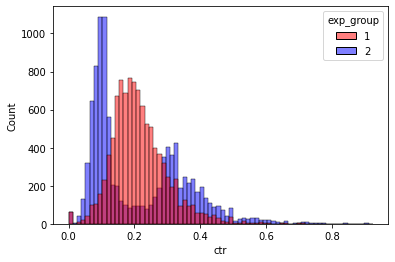

In [83]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Если посмотреть на распределение CTR глазами, можно видеть, что у 2 группы распределение не унимодально(либо скошено, но не хватает данных), что уже может стать причиной плохой работы Т-теста. Манна-Уитни скорее всего прокрасится, т.к. распределения отличаются по форме, и из логики работы рангового теста, группы будут отличаться.

In [84]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Можно посмотреть на распределение просмотров в каждой из групп, возможно что-то не так с пользовательским CTR.
Как видим из графика ниже, действительно, очень много пользователей имеют менне 50 лайков, что портит нам оценку CTR и предыдущий тест несостоятелен.

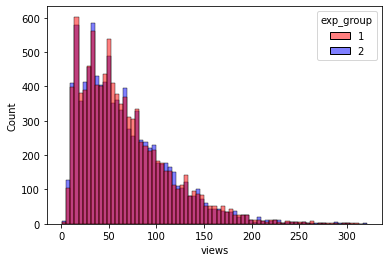

In [85]:
groups = sns.histplot(data = df, 
              x='views', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

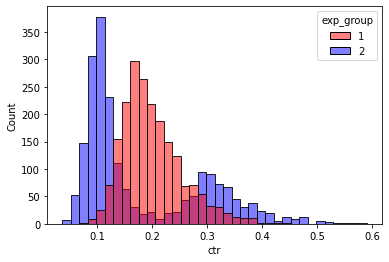

In [86]:
groups = sns.histplot(data = df[df['views']>=100], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Даже если смотреть только по пользователям, которым мы можем верить, в каком-то смысле, в плане CTR, видны два горба в группе номер 2(тестовая).
Возможно новый алгоритм подействовал на часть пользователей положительно, т.е. стал предлагать им больше постов, которые им интересны. А другой группе начал давать менее релевантные. Проблема, например, может крыться в том, что на новых пользователях алгоритм работает хуже (из-за недостатка данных), чем на старых. Либо хуже работать на пользователях, которые мало лайкали (было всего 2 лайка по которым алгоритм не смог сделать корректный вывод).  
Рассмотрим пользователей тестовой группы, поделив их по CTR

/tmp/ipykernel_89/2226139948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ctr_group'] = ['ctr<=20%' if x>0.2 else 'ctr>20%' for x in test_df.ctr]


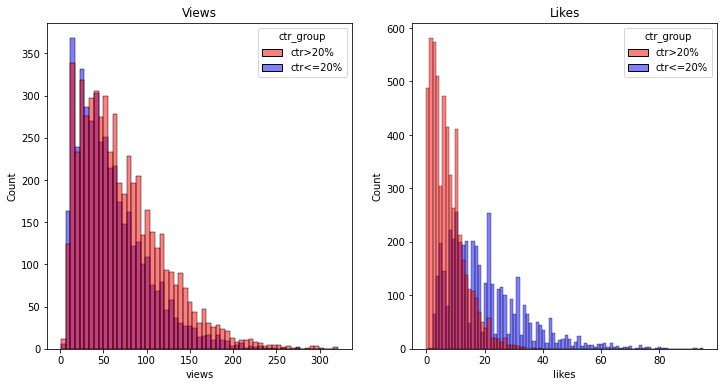

In [87]:
test_df = df[df.exp_group == 2]
test_df['ctr_group'] = ['ctr<=20%' if x>0.2 else 'ctr>20%' for x in test_df.ctr]

f, ax = plt.subplots(1,2,figsize=(12, 6))

ax1 = sns.histplot(data = test_df, 
              x='views', 
              hue='ctr_group', 
              palette = ['r', 'b'],
            ax=ax[0])
ax1.set_title('Views')
ax2 = sns.histplot(data = test_df, 
              x='likes', 
              hue='ctr_group', 
              palette = ['r', 'b'],
            ax=ax[1])
ax2.set_title('Likes')
f.show()

In [62]:
test_df.groupby('ctr_group')['user_id'].nunique()

ctr_group
ctr<=20%    4432
ctr>20%     5520
Name: user_id, dtype: int64

Группы по ctr примерно одинаковы по размеру, а распределение просмотров примерно совпадает. Правда у группы, с большим ctr, хвост тяжелее. Выглядит разумно, пользователям больше нравится контент - смотрят больше.

In [97]:
q = """
SELECT 
    user_id,
    country,
    os,
    gender,
    sum(action = 'like')/sum(action = 'view') as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (2)
GROUP BY  
    country,
    os,
    gender,
    user_id
"""

test = ph.read_clickhouse(q, connection=connection)

In [98]:
test['ctr_group'] = ['ctr<=20%' if x>0.2 else 'ctr>20%' for x in test_df.ctr]

In [110]:
table = test.pivot_table(columns = 'ctr_group', index='country', values = 'user_id', aggfunc = 'count',margins=True)
table#.div(table['All'], axis=0)*100

ctr_group,ctr<=20%,ctr>20%,All
country,,,
Azerbaijan,50,60,110
Belarus,88,116,204
Cyprus,5,7,12
Estonia,5,3,8
Finland,51,57,108
Kazakhstan,76,120,196
Latvia,1,6,7
Russia,3898,4833,8731
Switzerland,1,9,10


Какой-то явный признак, у кого ctr точно выше 20%, не удалось найти.

**Так как же тестировать?**

Вариант сглаженного CTR интересен, но мне не нравится наличие гиперпараметра и риска того, что его направленность не совпадает с направленностью общего количества кликов. Кроме того, у нас распределения не похожи по форме.  
Попробуем посмотреть на общий CTR.  
Поэтому буду использовать бакетное преобразование как быстрый вариант бутстрепа (данных у нас достаточно для разделения на группы)

Кроме того, т.к. я уже попробовала М-У и далее планирую еще сравнения, то логично будет использовать поправку Бонферрони.
Т.е. в моем случае alpha = 0.05/4 = 0.0125

## 2. Бакетное преобразование прямо в CH

In [90]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

%time df_bucket = ph.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative='two-sided')

CPU times: user 20.6 ms, sys: 66 µs, total: 20.6 ms
Wall time: 341 ms


MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

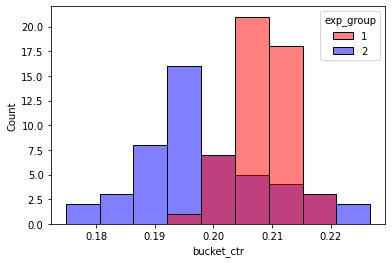

In [81]:
groups = sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Тут распределения уже унимодальные, однако у 2 группы ожидаемо больше дисперсия.
Тест общего CTR дал p-value меньше 0.025, а значит есть значимые изменения. Если посчитаем средние, то увидим, что у 2 группы он немного ниже.

In [82]:
df_bucket.groupby('exp_group')['bucket_ctr'].mean()

exp_group
1    0.208122
2    0.198259
Name: bucket_ctr, dtype: float64

## Пробуем другие методы
### Бутстреп - сравнение скорости и результатов

CPU times: user 2.52 s, sys: 695 ms, total: 3.21 s
Wall time: 3.23 s


<AxesSubplot:ylabel='Count'>

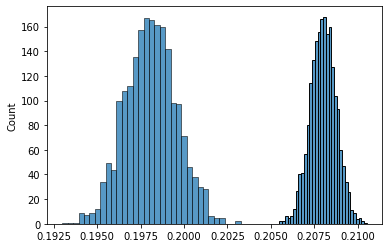

In [88]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

%time ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

In [93]:
#Т - тест видит отличие (можем применять его, т.к. распределения похожи на нормальные)
stats.ttest_ind(ctr1, ctr2, equal_var=False)

Ttest_indResult(statistic=268.98906140712825, pvalue=0.0)

### Сглаженный CTR

In [94]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

stats.mannwhitneyu(group1.smothed_ctr, 
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


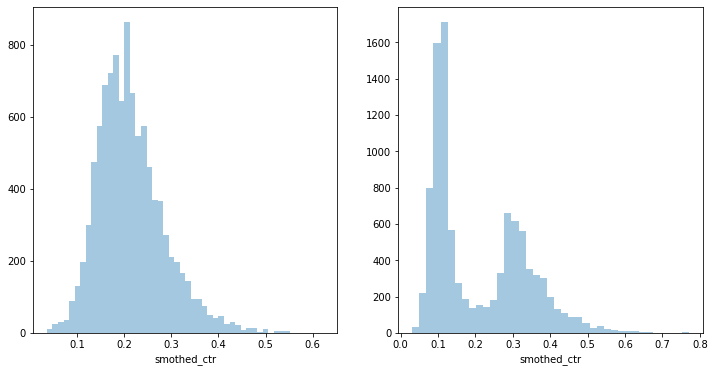

In [96]:
f, ax =  plt.subplots(1,2,figsize=(12, 6))
ax1 = sns.distplot(group1.smothed_ctr, 
             kde = False, ax=ax[0])
ax1 = sns.distplot(group2.smothed_ctr, 
             kde = False, ax=ax[1])

Распределения сгладились,во второй группе CTR приблизился к общегрупповому, который ниже

## Итоги

Результат теста в статистическом плане - отрицательный. Тесты нашли значимое различие между группами, причем в тестовой группе общий CTR ниже.
Однако, нами получено важное знание: алгоритм по-разному отработал на разных людях. Поэтому стоит подробнее посмотреть на людей из 2 группы по параметрам: времени в проекте, соц.дем, устройствам. Вероятно стоит немного доработать этот же алгоритм и попробовать снова.